Cargar los datos de kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_root = "/content/drive/MyDrive/MasterKISA/ITSDA/Entrega1/m5-forecasting-accuracy/"

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from datetime import date
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
calendar = pd.read_csv(os.path.join(data_root, "calendar.csv"))
calendar_reduced = calendar.iloc[:1913]
calendar_reduced.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
sales = pd.read_csv(os.path.join(data_root, "sales_train_validation.csv"))
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
sales_eval = pd.read_csv(os.path.join(data_root, "sales_train_evaluation.csv"))
sales_eval.head()
start_pos_eval = sales_eval.columns.get_loc('d_1')

total_sales_eval = sales_eval.iloc[:, start_pos_eval:].sum()
print(total_sales_eval.head())

d_1    32631
d_2    31749
d_3    23783
d_4    25412
d_5    19146
dtype: int64


1913

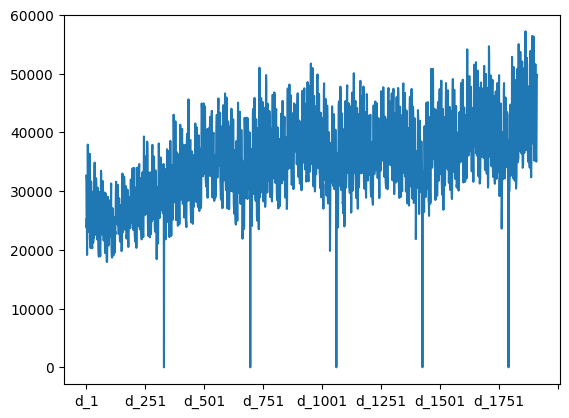

In [7]:
# Ventas totales por día
start_pos = sales.columns.get_loc('d_1')

total_sales = sales.iloc[:, start_pos:].sum()
total_sales.plot()
# total_sales[total_sales < 1000]
total_sales.size

Hacer el forecast con un metodo simple para total_sales (con todas las ventas de todo).
Hacer forecast por producto o por tienda.

In [8]:
!pip install xgboost

In [9]:
# Crear caracteristicas de la serie temporal
fechas = pd.date_range(start='2011-01-29', periods=len(total_sales), freq="D")
serie = pd.Series(total_sales.values, index=fechas)
data = serie.to_frame(name='total_sales')
data.reset_index(drop=True, inplace=True)
calendar_reduced.reset_index(drop=True, inplace=True)
fecha = pd.to_datetime(calendar_reduced['date'])

data['wday'] = calendar_reduced['wday']
data['day'] = fecha.dt.day
data['month'] = calendar_reduced['month']
data['year'] = calendar_reduced['year']
data['event_name_1'] = calendar_reduced['event_name_1'].notna()
data['event_name_2'] = calendar_reduced['event_name_2'].notna()

Mejor modelo: {'params': {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 13}, 'rmse': 1911.534880102822, 'model': XGBRegressor(alpha=13, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, ...)}


<ipython-input-35-7577173e8ae1>:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Cinco De Mayo' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fechas_futuras.loc[i, 'event_name_1'] = calendar_reduced.loc[1546+i, 'event_name_1']


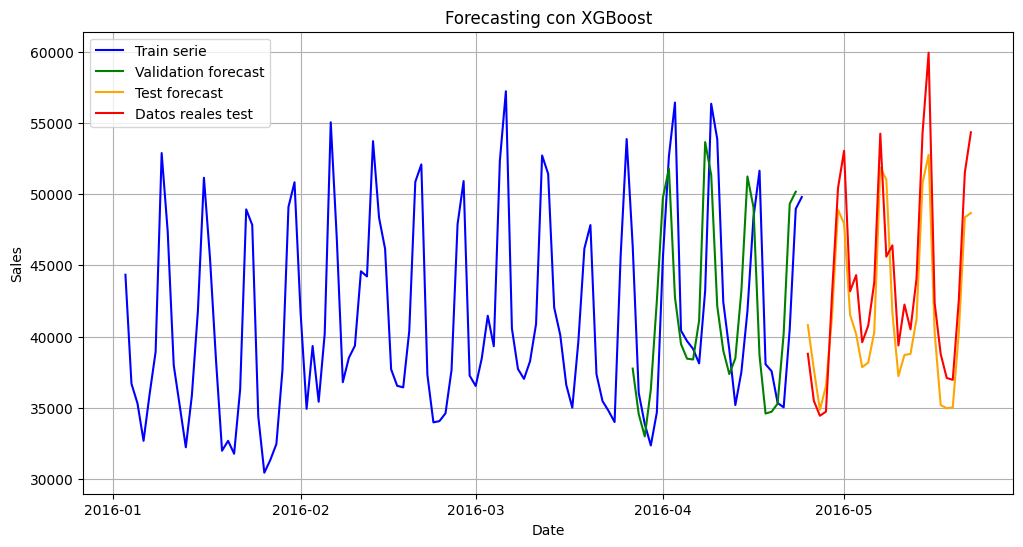

Validation error (RMSE): 1911.534880102822
Test error (RMSE): 3309.1463144813383


In [35]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def train_and_validate_xgb(X, y, param_ranges):
    """
    Entrena y valida modelos XGBRegressor con diferentes combinaciones de hiperparámetros.

    Args:
        X (pd.DataFrame): DataFrame con las features.
        y (pd.Series): Serie con la variable objetivo.
        param_ranges (dict): Diccionario con los rangos de valores de hiperparámetros a probar.

    Returns:
        dict: Información del mejor modelo (parámetros, error y el modelo en sí).
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.0146, shuffle=False)

    best_model_info = {"params": None, "rmse": float("inf"), "model": None}

    for n_estimators in param_ranges["n_estimators"]:
        for learning_rate in param_ranges["learning_rate"]:
            for max_depth in param_ranges["max_depth"]:
                for alpha in param_ranges["alpha"]:
                  params = {
                      "n_estimators": n_estimators,
                      "learning_rate": learning_rate,
                      "max_depth": max_depth,
                      "alpha": alpha
                  }

                  model = XGBRegressor(random_state=42, **params)
                  model.fit(X_train, y_train)

                  y_val_pred = model.predict(X_val)
                  rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                  if rmse < best_model_info["rmse"]:
                      best_model_info = {"params": params, "rmse": rmse, "model": model}

    return best_model_info

def plot_forecast(best_model, X_val, y_val, fechas_futuras, fechas_val, total_sales_eval, dates):
    """
    Realiza el gráfico del modelo con menor error.

    Args:
        best_model (XGBRegressor): Modelo XGBRegressor con el menor error.
        X_val (pd.DataFrame): Conjunto de validación.
        y_val (pd.Series): Valores reales del conjunto de validación.
        fechas_futuras (pd.DataFrame): DataFrame con las features de las fechas futuras.
        fechas_val (pd.DataFrame): DataFrame con las fechas del conjunto de validación.
        total_sales_eval (pd.Series): Valores reales del conjunto de prueba para comparar.

    """
    y_val_pred = best_model.predict(X_val)
    future_predictions = best_model.predict(fechas_futuras)

    fechas_futuras['date'] = dates
    plt.figure(figsize=(12, 6))
    plt.plot(serie[1800:], label="Train serie", color="blue")
    plt.plot(fechas_val, y_val_pred, label="Validation forecast", color="green")
    plt.plot(fechas_futuras['date'], future_predictions, label="Test forecast", color="orange")
    plt.plot(fechas_futuras['date'], total_sales_eval[1913:], label="Datos reales test", color="red")
    plt.title("Forecasting con XGBoost")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

    test_rmse = np.sqrt(mean_squared_error(total_sales_eval[1913:], future_predictions))
    print(f"Validation error (RMSE): {best_model_info['rmse']}")
    print(f"Test error (RMSE): {test_rmse}")

# Ejemplo de uso:
# Definir los rangos de hiperparámetros a explorar
param_ranges = {
    "n_estimators": [180, 190, 200, 210, 220, 250],
    "learning_rate": [0.08, 0.09, 0.1, 0.11],
    "max_depth": [4, 5, 6],
    "alpha": [11, 12, 13]
}

# Obtener el mejor modelo
X = data.drop(columns="total_sales")
y = data["total_sales"]
best_model_info = train_and_validate_xgb(X, y, param_ranges)
print(f"Mejor modelo: {best_model_info}")

# Crear el dataframe con las mismas features que el train/test.
date_range = pd.date_range(start='2016-04-25', periods=28)
fechas_futuras = pd.DataFrame({
    'date': date_range,
    'wday': date_range.weekday + 3,  # Días de la semana (1=Lunes, 7=Domingo)
    'day': date_range.day,
    'month': date_range.month,
    'year': date_range.year
})

for i in fechas_futuras.index:
  if fechas_futuras.loc[i, 'wday'] >=8:
    fechas_futuras.loc[i, 'wday'] = fechas_futuras.loc[i, 'wday'] -7

for i in range(28):
  fechas_futuras.loc[i, 'event_name_1'] = calendar_reduced.loc[1546+i, 'event_name_1']
  fechas_futuras.loc[i, 'event_name_2'] = calendar_reduced.loc[1546+i, 'event_name_2']

fechas_futuras['event_name_1'] = fechas_futuras['event_name_1'].notna()
fechas_futuras['event_name_2'] = fechas_futuras['event_name_2'].notna()

# Limpiar columnas innecesarias
dates = fechas_futuras['date']
fechas_futuras = fechas_futuras.drop(columns=['date'])

# Graficar las predicciones
plot_forecast(
    best_model_info["model"],
    X_val,
    y_val,
    fechas_futuras,
    fechas_val,
    total_sales_eval,
    dates
)


De los parametros que se han probado los que mejor funcionan son:

'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 13, 'rmse validation': 1911.534880102822

El error de test (RMSE): 3309.1463144813383

ARIMA

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=20.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=38649.513, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=37412.200, Time=2.43 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=37890.868, Time=5.53 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=38647.518, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=38644.729, Time=0.20 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=37140.674, Time=6.35 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=37061.519, Time=12.58 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=37221.619, Time=7.37 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=13.38 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=36987.362, Time=12.20 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.67 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=37361.556, Time=8.25 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : A

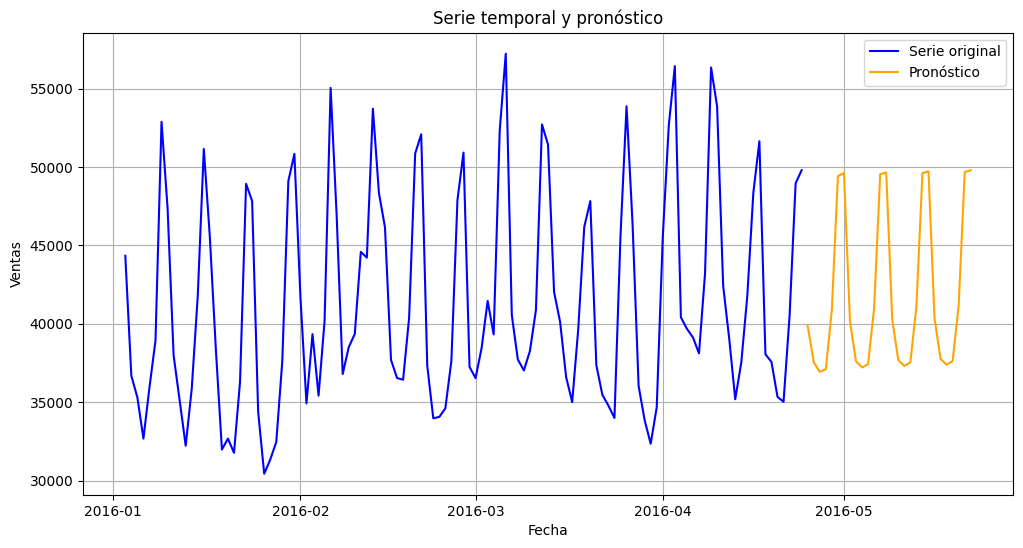

Test error: 13960371.534685235


In [ ]:
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
# Esto esta hecho sinmas, le tengo que meter un repaso.

modelo = auto_arima(serie, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(modelo.summary())

model_arima = ARIMA(serie, order=modelo.order, seasonal_order=modelo.seasonal_order).fit()
pronostico_arima = model_arima.forecast(steps=28)

plt.figure(figsize=(12, 6))
plt.plot(serie[1800:], label="Serie original", color="blue")
plt.plot(pronostico_arima, label="Pronóstico", color="orange")
plt.title("Serie temporal y pronóstico")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

error = mean_squared_error(total_sales_eval[1913:], pronostico_arima)
print("Test error:", str(error))

In [14]:
error = np.sqrt(mean_squared_error(total_sales_eval[1913:], pronostico_arima))
print("Test error:", str(error))

NameError: name 'pronostico_arima' is not defined